## Import dependencies

In [8]:
import json
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

## Set random seed for reproducibility

In [3]:

np.random.seed(42)
tf.random.set_seed(42)

## Helper functions

In [16]:
def load_data(file_path):
    """
    Load and preprocess the face tracking data.

    Args:
        file_path: Path to the JSON file containing face tracking data

    Returns:
        X: Feature array of shape (n_samples, sequence_length, n_features)
        y: Labels array
    """
    # Load the JSON data
    with open(file_path, 'r') as f:
        data = json.load(f)

    X = []
    y = []

    for entry in data:
        # Extract coordinates and convert to numpy array
        coords = np.array(entry['coordinates'])

        # Ensure all sequences have the same length
        if coords.shape[0] == entry['sequenceLength']:
            # Normalize coordinates if not already normalized
            if np.max(coords) > 1.0:
                coords = coords / np.max(coords)

            # Add to features and labels
            X.append(coords)
            y.append(entry['activityType'])

    # Convert to numpy arrays
    X = np.array(X)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Convert to categorical
    y_categorical = to_categorical(y_encoded)

    return X, y_categorical, label_encoder.classes_

def apply_augmentation(X, y, augmentation_factor=2):
    """
    Apply various data augmentation techniques to 1D time series data.

    Args:
        X: Original feature array of shape (n_samples, sequence_length, n_features)
        y: Original labels array
        augmentation_factor: Factor by which to increase the dataset size

    Returns:
        Augmented X and y arrays

    Note:
        This function handles edge cases with sequence length mismatches during warping.
    """
    n_samples, seq_length, n_features = X.shape
    X_augmented = [X]
    y_augmented = [y]

    # Calculate how many augmented samples to generate for each technique
    samples_per_technique = int(n_samples * (augmentation_factor - 1) / 4)

    # 1. Time warping (stretching and compressing)
    for _ in range(samples_per_technique):
        idx = np.random.randint(0, n_samples)
        sample = X[idx].copy()

        # Random time warping factor between 0.8 and 1.2
        warp_factor = np.random.uniform(0.8, 1.2)

        # Create new timestamps
        original_steps = np.arange(seq_length)
        warped_steps = np.linspace(0, seq_length-1, int(seq_length * warp_factor))

        # Resample to original length
        warped_sample = np.zeros_like(sample)
        for i in range(n_features):
            # Use linear interpolation (handle case when warped_steps is longer than sample)
            warped_sample[:, i] = np.interp(
                original_steps,
                np.linspace(0, seq_length-1, min(len(warped_steps), len(sample))),
                sample[:min(len(warped_steps), len(sample)), i])

        X_augmented.append(np.expand_dims(warped_sample, axis=0))
        y_augmented.append(np.expand_dims(y[idx], axis=0))

    # 2. Magnitude warping (scaling amplitude)
    for _ in range(samples_per_technique):
        idx = np.random.randint(0, n_samples)
        sample = X[idx].copy()

        # Random scaling factors for each feature
        scale_factors = np.random.uniform(0.7, 1.3, size=n_features)

        for i in range(n_features):
            sample[:, i] *= scale_factors[i]

        X_augmented.append(np.expand_dims(sample, axis=0))
        y_augmented.append(np.expand_dims(y[idx], axis=0))

    # 3. Jittering (adding noise)
    for _ in range(samples_per_technique):
        idx = np.random.randint(0, n_samples)
        sample = X[idx].copy()

        # Add random noise
        noise_level = np.random.uniform(0.005, 0.02)
        noise = np.random.normal(0, noise_level, size=sample.shape)
        sample += noise

        X_augmented.append(np.expand_dims(sample, axis=0))
        y_augmented.append(np.expand_dims(y[idx], axis=0))

    # 4. Permutation (swapping segments)
    for _ in range(samples_per_technique):
        idx = np.random.randint(0, n_samples)
        sample = X[idx].copy()

        # Define number of segments (2-5)
        n_segments = np.random.randint(2, min(6, seq_length//5))

        # Create segments of roughly equal size
        segment_points = np.linspace(0, seq_length, n_segments+1, dtype=int)
        segments = []

        for i in range(n_segments):
            start = segment_points[i]
            end = segment_points[i+1]
            segments.append(sample[start:end].copy())

        # Shuffle segments (but ensure at least one swap)
        original_order = list(range(n_segments))
        new_order = original_order.copy()
        while new_order == original_order:
            np.random.shuffle(new_order)

        # Reconstruct the sample with shuffled segments
        new_sample = np.zeros_like(sample)
        current_idx = 0

        for i in new_order:
            segment = segments[i]
            segment_len = len(segment)
            new_sample[current_idx:current_idx+segment_len] = segment
            current_idx += segment_len

        X_augmented.append(np.expand_dims(new_sample, axis=0))
        y_augmented.append(np.expand_dims(y[idx], axis=0))

    # Concatenate all augmented data
    X_augmented = np.vstack(X_augmented)
    y_augmented = np.vstack(y_augmented)

    return X_augmented, y_augmented

def visualize_augmentations(original, augmented, original_label, class_names):
    """
    Visualize original and augmented samples for comparison.

    Args:
        original: Original sample
        augmented: List of augmented samples
        original_label: Label of the original sample
        class_names: Array of class names
    """
    n_augmentations = len(augmented)
    label_name = class_names[np.argmax(original_label)]

    plt.figure(figsize=(15, 3 * (n_augmentations + 1)))

    # Plot original sample
    plt.subplot(n_augmentations + 1, 2, 1)
    plt.plot(original[:, 0])
    plt.title(f'Original - X Coord - {label_name}')
    plt.ylabel('Value')

    plt.subplot(n_augmentations + 1, 2, 2)
    plt.plot(original[:, 1])
    plt.title(f'Original - Y Coord - {label_name}')

    # Plot augmented samples
    for i, aug in enumerate(augmented):
        plt.subplot(n_augmentations + 1, 2, 2*i + 3)
        plt.plot(aug[:, 0])
        plt.title(f'Augmentation {i+1} - X Coord')
        plt.ylabel('Value')

        plt.subplot(n_augmentations + 1, 2, 2*i + 4)
        plt.plot(aug[:, 1])
        plt.title(f'Augmentation {i+1} - Y Coord')

    plt.tight_layout()
    plt.savefig(f'outputs/visualizations/augmentation_examples_{label_name}.png')
    plt.show()

def create_model(input_shape, num_classes):
    """
    Create a 1D CNN model for activity classification.

    Args:
        input_shape: Shape of input data (sequence_length, n_features)
        num_classes: Number of classes to predict

    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # First convolutional layer
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),

        # Second convolutional layer
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),

        # Third convolutional layer
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),

        # Flatten the output and feed it into dense layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_data_generator(X, y, batch_size=32, augment_online=True):
    """
    Create a data generator that applies random augmentations on-the-fly.

    Args:
        X: Feature array
        y: Labels array
        batch_size: Batch size
        augment_online: Whether to apply augmentation on-the-fly

    Returns:
        Generator that yields batches of (X, y)
    """
    n_samples = X.shape[0]
    indices = np.arange(n_samples)

    while True:
        # Shuffle indices each epoch
        np.random.shuffle(indices)

        for i in range(0, n_samples, batch_size):
            # Get batch indices
            batch_indices = indices[i:i+batch_size]
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

            # Apply augmentation with 50% probability if enabled
            if augment_online and np.random.random() < 0.5:
                X_batch_aug = []
                y_batch_aug = []

                for j in range(len(X_batch)):
                    # Choose a random augmentation technique
                    aug_type = np.random.choice([
                        'jitter', 'scale', 'warp', 'none'
                    ])

                    sample = X_batch[j].copy()

                    if aug_type == 'jitter':
                        # Add random noise
                        noise_level = np.random.uniform(0.005, 0.02)
                        noise = np.random.normal(0, noise_level, size=sample.shape)
                        sample += noise

                    elif aug_type == 'scale':
                        # Scale features randomly
                        scale_factors = np.random.uniform(0.7, 1.3, size=sample.shape[1])
                        for k in range(sample.shape[1]):
                            sample[:, k] *= scale_factors[k]

                    elif aug_type == 'warp':
                        # Time warping
                        seq_length = sample.shape[0]
                        n_features = sample.shape[1]
                        warp_factor = np.random.uniform(0.8, 1.2)

                        original_steps = np.arange(seq_length)
                        warped_steps = np.linspace(0, seq_length-1, int(seq_length * warp_factor))

                        warped_sample = np.zeros_like(sample)
                        for k in range(n_features):
                            # Safe interpolation to handle mismatched lengths
                            warped_sample[:, k] = np.interp(
                                original_steps,
                                np.linspace(0, seq_length-1, min(len(warped_steps), seq_length)),
                                sample[:min(len(warped_steps), seq_length), k]
                            )
                        sample = warped_sample

                    X_batch_aug.append(sample)
                    y_batch_aug.append(y_batch[j])

                X_batch = np.array(X_batch_aug)
                y_batch = np.array(y_batch_aug)

            yield X_batch, y_batch

def train_and_evaluate():
    """
    Main function to train and evaluate the model.
    """
    # Load and preprocess data
    file_path = 'face_tracking_data.json'
    X, y, class_names = load_data(file_path)

    # Get dimensions
    n_samples, seq_length, n_features = X.shape
    print(f"Original dataset shape: {X.shape}, {len(class_names)} classes: {class_names}")

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Perform offline data augmentation for training set
    print("Applying data augmentation...")
    X_train_aug, y_train_aug = apply_augmentation(X_train, y_train, augmentation_factor=3)
    print(f"Augmented dataset shape: {X_train_aug.shape}")

    # Visualize augmentations for sample
    if X_train.shape[0] > 0:
        original_sample = X_train[0]
        original_label = y_train[0]

        # Generate a few different augmentations for the same sample
        augmented_samples = []
        for _ in range(4):
            # Apply each augmentation type once
            # Jittering
            sample = original_sample.copy()
            noise_level = 0.015
            noise = np.random.normal(0, noise_level, size=sample.shape)
            augmented_samples.append(sample + noise)

            # Magnitude scaling
            sample = original_sample.copy()
            scale_factors = np.random.uniform(0.7, 1.3, size=n_features)
            for i in range(n_features):
                sample[:, i] *= scale_factors[i]
            augmented_samples.append(sample)

            # Time warping
            sample = original_sample.copy()
            warp_factor = 1.2
            original_steps = np.arange(seq_length)
            warped_steps = np.linspace(0, seq_length-1, int(seq_length * warp_factor))

            warped_sample = np.zeros_like(sample)
            for i in range(n_features):
                # Safe interpolation handling
                warped_sample[:, i] = np.interp(
                    original_steps,
                    np.linspace(0, seq_length-1, min(len(warped_steps), seq_length)),
                    sample[:min(len(warped_steps), seq_length), i]
                )
            augmented_samples.append(warped_sample)

            # Permutation
            sample = original_sample.copy()
            n_segments = 3
            segment_points = np.linspace(0, seq_length, n_segments+1, dtype=int)
            segments = []

            for i in range(n_segments):
                start = segment_points[i]
                end = segment_points[i+1]
                segments.append(sample[start:end].copy())

            np.random.shuffle(segments)

            new_sample = np.zeros_like(sample)
            current_idx = 0

            for segment in segments:
                segment_len = len(segment)
                new_sample[current_idx:current_idx+segment_len] = segment
                current_idx += segment_len

            augmented_samples.append(new_sample)

        visualize_augmentations(original_sample, augmented_samples, original_label, class_names)

    # Create and compile the model
    model = create_model(input_shape=(seq_length, n_features), num_classes=len(class_names))
    model.summary()

    # Create data generators for online augmentation
    train_generator = create_data_generator(X_train_aug, y_train_aug, batch_size=32, augment_online=True)
    val_generator = create_data_generator(X_test, y_test, batch_size=32, augment_online=False)

    # Calculate steps per epoch
    steps_per_epoch = len(X_train_aug) // 32
    validation_steps = len(X_test) // 32 or 1  # At least 1 step

    # Train the model with data generators
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=50,
        validation_data=val_generator,
        validation_steps=validation_steps,
        verbose=1
    )

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {accuracy:.4f}")

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig('outputs/visualizations/training_history_with_augmentation.png')
    plt.show()

    # Save the model in Keras format
    model.save('outputs/models/face_activity_classifier_with_augmentation.h5')
    print("Model saved as 'outputs/models/face_activity_classifier_with_augmentation.h5'")

    # Export to TensorFlow Lite format
    export_to_tflite(model, 'outputs/models/face_activity_classifier_with_augmentation.tflite', class_names)

    return model, history, class_names

def visualize_sample(X, y, class_names, sample_idx=0):
    """
    Visualize a sample sequence from the dataset.

    Args:
        X: Feature array
        y: Labels array
        class_names: Array of class names
        sample_idx: Index of the sample to visualize
    """
    sample = X[sample_idx]
    label = class_names[np.argmax(y[sample_idx])]

    plt.figure(figsize=(10, 6))

    # Plot X coordinates
    plt.subplot(2, 1, 1)
    plt.plot(sample[:, 0])
    plt.title(f'X Coordinates - {label}')
    plt.ylabel('X Position')

    # Plot Y coordinates
    plt.subplot(2, 1, 2)
    plt.plot(sample[:, 1])
    plt.title(f'Y Coordinates - {label}')
    plt.ylabel('Y Position')
    plt.xlabel('Frame Number')

    plt.tight_layout()
    plt.savefig(f'outputs/visualizations/sample_{label}.png')
    plt.show()

def export_to_tflite(model, output_path, class_names=None):
    """
    Export Keras model to TensorFlow Lite format for mobile deployment.

    Args:
        model: Trained Keras model
        output_path: Path to save the TFLite model
        class_names: Optional list of class names for metadata
    """
    # Convert the model to TensorFlow Lite format
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Apply optimizations
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Quantize the model to reduce size (optional)
    converter.target_spec.supported_types = [tf.float16]

    # Convert the model
    tflite_model = converter.convert()

    # Save the model to disk
    with open(output_path, 'wb') as f:
        f.write(tflite_model)

    # Get the file size in KB
    file_size = round(len(tflite_model) / 1024, 2)
    print(f"TensorFlow Lite model saved at {output_path} ({file_size} KB)")

    # # Generate metadata file with class labels
    # try:
    #     # Get input and output shapes from model config
    #     input_shape = model.layers[0].input_shape
    #     output_shape = model.layers[-1].output_shape

    #     # Create metadata using shapes from model config
    #     metadata = {
    #         'input_shape': input_shape[0] if isinstance(input_shape, list) else input_shape,
    #         'output_shape': output_shape[0] if isinstance(output_shape, list) else output_shape,
    #         'class_names': list(class_names) if 'class_names' in locals() else []
    #     }

    #     # Save metadata to file
    #     with open(output_path.replace('.tflite', '_metadata.json'), 'w') as f:
    #         json.dump(metadata, f, indent=2)

    #     print(f"Model metadata saved at {output_path.replace('.tflite', '_metadata.json')}")
    # except Exception as e:
    #     print(f"Failed to save metadata: {e}")

def predict_new_sequence(model, new_data, class_names):
    """
    Predict the activity for a new sequence.

    Args:
        model: Trained Keras model
        new_data: New sequence data of shape (1, sequence_length, n_features)
        class_names: Array of class names

    Returns:
        Predicted class and probability
    """
    # Make prediction
    prediction = model.predict(new_data)
    predicted_class_idx = np.argmax(prediction[0])
    predicted_class = class_names[predicted_class_idx]
    probability = prediction[0][predicted_class_idx]

    return predicted_class, probability


## Create directories for output

In [6]:
# Create directories for output
os.makedirs('outputs', exist_ok=True)
os.makedirs('outputs/visualizations', exist_ok=True)
os.makedirs('outputs/models', exist_ok=True)

  ## Train and evaluate the model

Original dataset shape: (132, 100, 2), 2 classes: ['standing' 'walking']
Applying data augmentation...
Augmented dataset shape: (313, 100, 2)


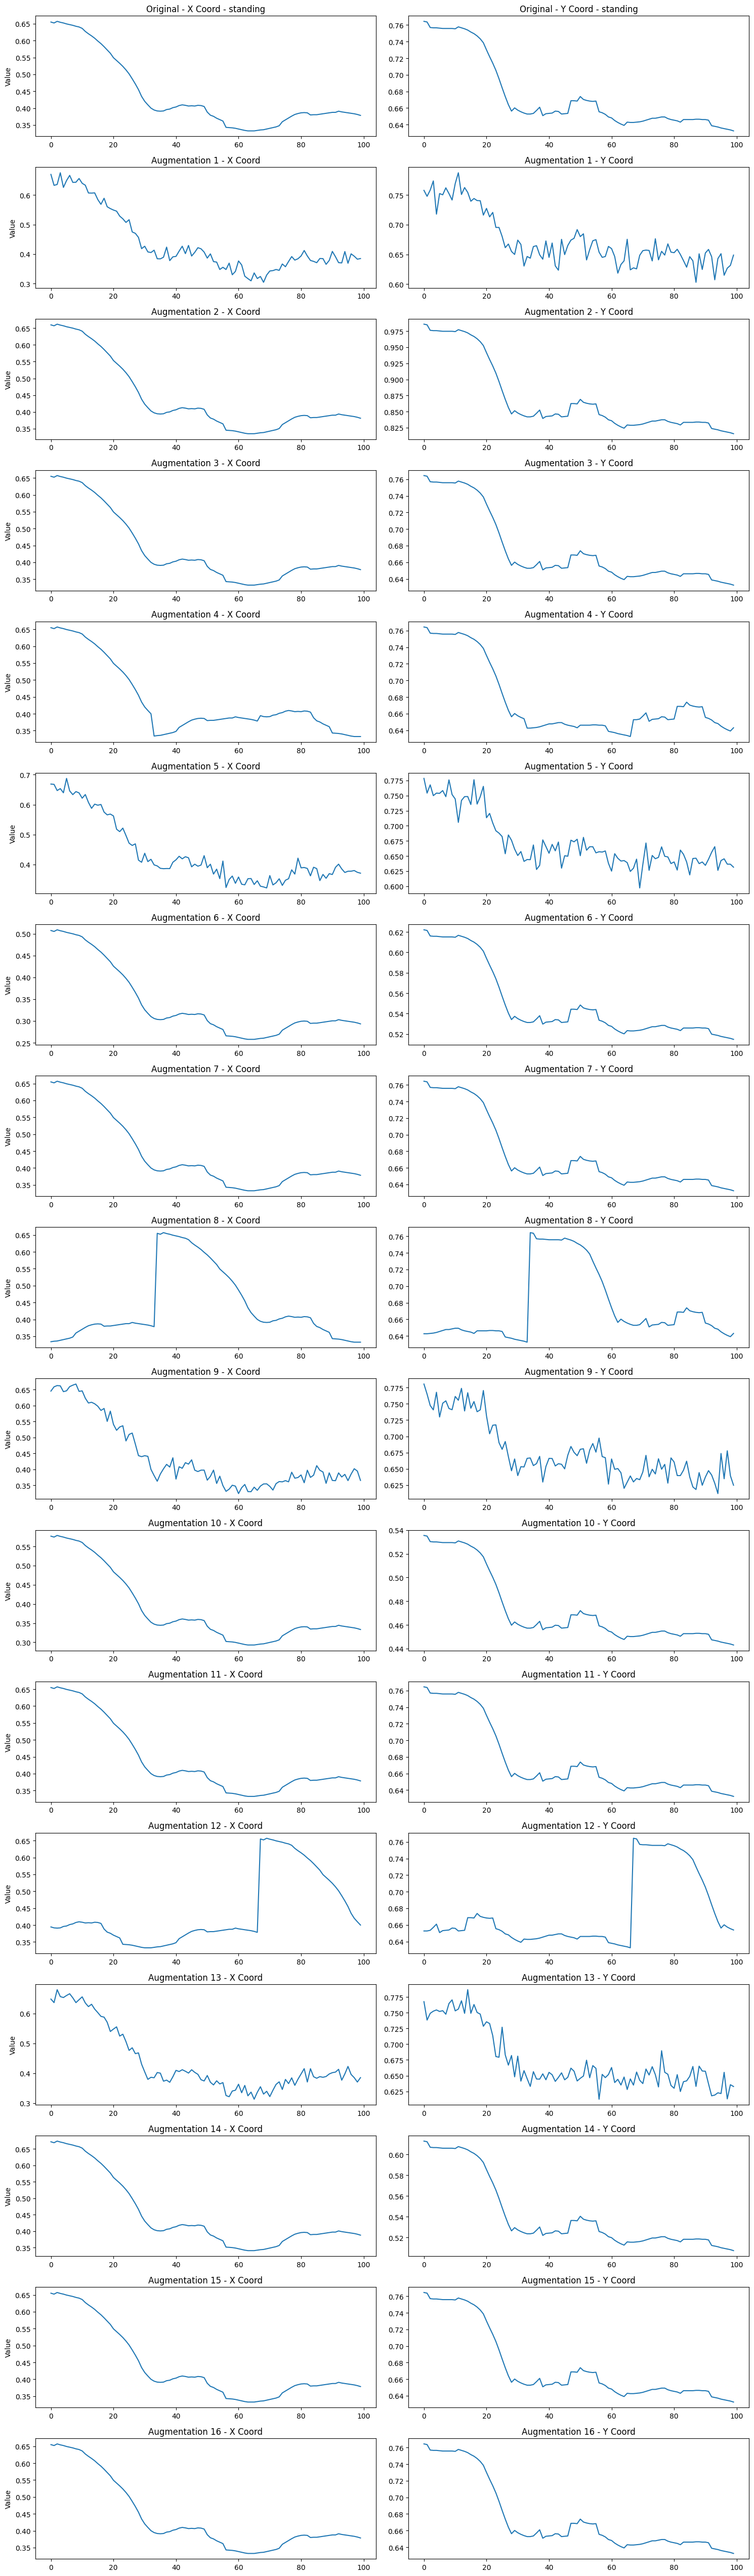

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 98, 64)              │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 49, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 47, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 23, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 21, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 238,658 (932.26 KB)

 Trainable params: 238,658 (932.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5775 - loss: 0.7193 - val_accuracy: 0.5556 - val_loss: 0.7160
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6902 - loss: 0.6199 - val_accuracy: 0.6667 - val_loss: 0.6214
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7689 - loss: 0.5392 - val_accuracy: 0.6667 - val_loss: 0.6675
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6456 - loss: 0.5944 - val_accuracy: 0.6296 - val_loss: 0.8055
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6736 - loss: 0.5706 - val_accuracy: 0.6296 - val_loss: 0.8297
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7570 - loss: 0.4751 - val_accuracy: 0.6296 - val_loss: 0.8699
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7542 - loss: 0.4995 - val_accuracy: 0.6296 - val_loss: 0.9059
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8200 - loss: 0.3973 - val_accuracy: 0.7407 - val_loss: 0.9607


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


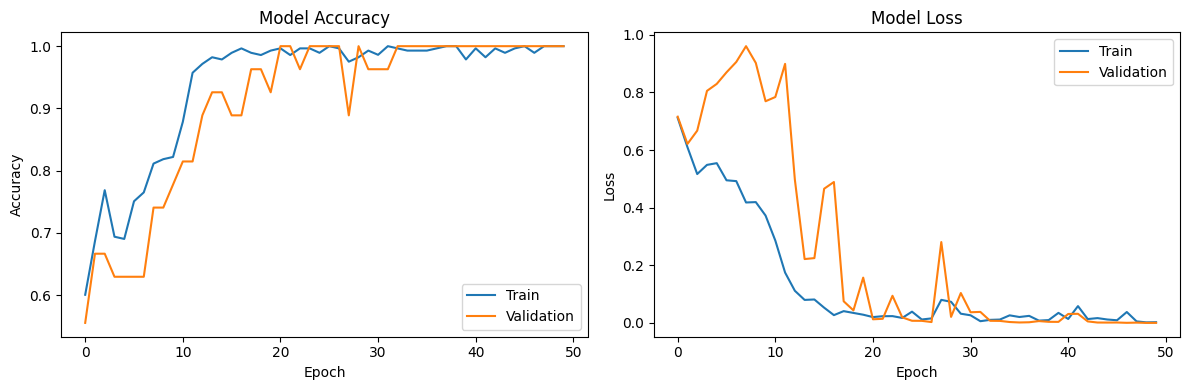

Model saved as 'outputs/models/face_activity_classifier_with_augmentation.h5'
Saved artifact at '/tmp/tmpm0c26gzh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 2), dtype=tf.float32, name='keras_tensor_44')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134802358699792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134802358707280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134802358704784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134802358713616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134802358709200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134802358705168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134802358706896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134802242815184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134802242821904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13480224

In [17]:
model, history, class_names = train_and_evaluate()

## Visualization

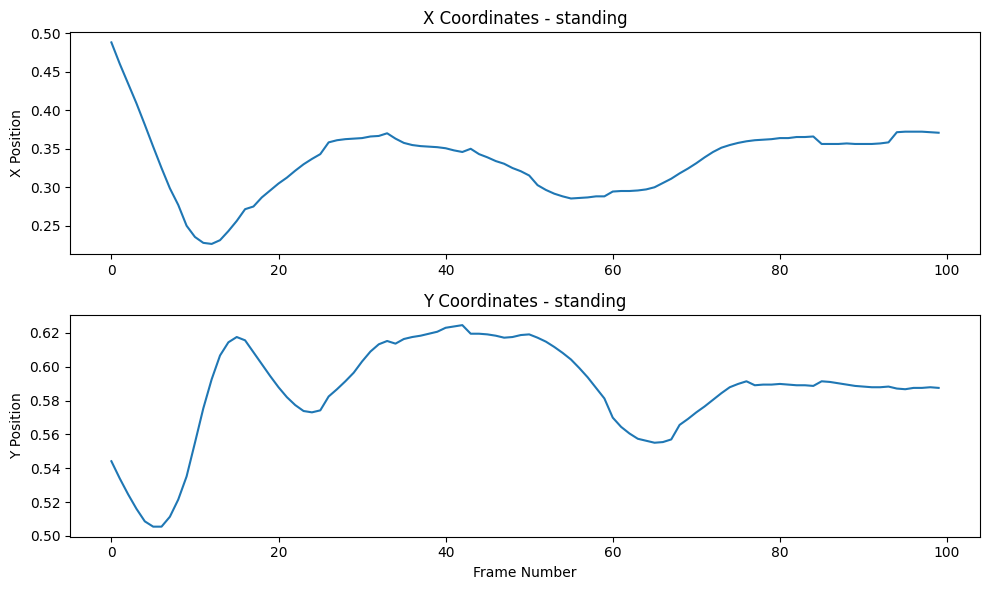

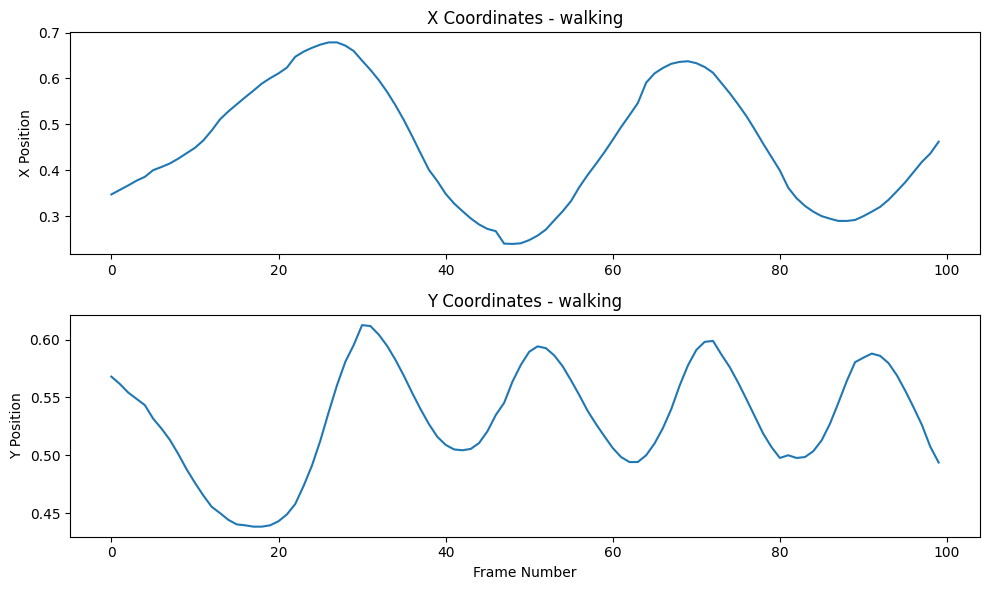

Class names saved to outputs/models/class_names.json
Training and evaluation complete!
The TFLite model can now be included in your Flutter app's assets folder


In [18]:
    # Load data for visualization
    X, y, _ = load_data('face_tracking_data.json')

    # Visualize sample activities
    for class_idx, class_name in enumerate(class_names):
        # Find samples of this class
        class_indices = np.where(np.argmax(y, axis=1) == class_idx)[0]
        if len(class_indices) > 0:
            visualize_sample(X, y, class_names, sample_idx=class_indices[0])

    # Save class names to a JSON file for use in Flutter
    with open('outputs/models/class_names.json', 'w') as f:
        json.dump({'class_names': list(class_names)}, f)
        print("Class names saved to outputs/models/class_names.json")

    print("Training and evaluation complete!")
    print("The TFLite model can now be included in your Flutter app's assets folder")